Audio Neural Style Transfer with Pytorch
============================
This is an implementation of neural style transfer for audio adapted from [An implementation of Neural Style Transfer for Audio using Pytorch](https://github.com/muhdhuz/Audio_NeuralStyle) by Muhammad Huzaifah.

In [ ]:
# for processing audio
!pip install librosa==0.7.2

In [ ]:
# using Google Colab for GPU
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/MRP')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

from __future__ import print_function

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import librosa
import librosa.display
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats

import torchvision.transforms as transforms
import torchvision.models as models
from audiocnn import CNN 

import copy
import math

In [ ]:
use_cuda = torch.cuda.is_available() #use GPU if available
print('GPU available =', use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

GPU available = True


In [ ]:
#set seed 
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# set filenames
STYLE_FILENAME = '5-263831-B-6.wav' # style input filename
savename_style = 'hens_avg' # output filename
CONTENT_FILENAME = '5-180156-B-43.wav' # content input filename, None if doing texture synthesis

runs = 1 # no. of separate outputs (to test consistency), 1 if only want single output

#librosa audio params
K_HOP = 128 # hop length

# for STFT
N_FFT = 1024 # window length

# for CQT
BINS = 512 # frequency bins
BPO = 64 # bins per octave

# hyperparameters to be varied
INPUT_TYPE = 'stft' # 'stft' or 'cqt'
POOL_TYPE = 'avg' # 'max' or 'avg' 

In [ ]:
display(Audio(STYLE_FILENAME))

In [ ]:
def read_audio_spectrum(filename):
    x, fs = librosa.load(filename) #x=audiodata, fs=samplerate
    if INPUT_TYPE == 'stft':
        R = np.abs(librosa.stft(x, n_fft=N_FFT, hop_length=K_HOP, win_length=N_FFT, center=True))
    elif INPUT_TYPE == 'cqt':
        R = np.abs(librosa.cqt(x, hop_length=K_HOP, n_bins=BINS, bins_per_octave=BPO))
    return R, fs

def log_scale(img):
    img = np.log1p(img)
    return img

def inv_log(img):
    img = np.exp(img) - 1.
    return img


(513, 862)
range before scaling: 4.394256e-08 98.57939
range after log scaling: 4.394256e-08 4.600955
Input shape: torch.Size([1, 513, 1, 862])


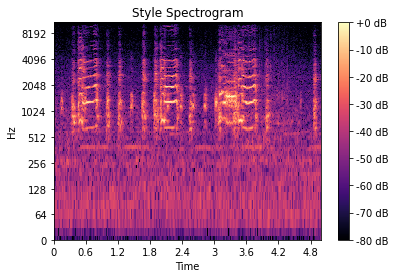

In [ ]:
R, fs = read_audio_spectrum(STYLE_FILENAME)
print(R.shape)
print("range before scaling:", np.amin(R),np.amax(R))
a_style = log_scale(R[:,:])
print("range after log scaling:", np.amin(a_style),np.amax(a_style)) #necessary for cqt?

 
#plot style spectrogram
plt.figure()
if INPUT_TYPE == 'stft':
    librosa.display.specshow(librosa.amplitude_to_db(R, ref=np.max), 
                                   hop_length=K_HOP, y_axis='log', 
                                   x_axis='time')
elif INPUT_TYPE == 'cqt':
    librosa.display.specshow(librosa.amplitude_to_db(R, ref=np.max), 
                             hop_length=K_HOP, bins_per_octave=BPO, 
                             x_axis='time', y_axis='cqt_hz')

plt.title('Style Spectrogram')
plt.colorbar(format="%+2.0f dB")


N_SAMPLES = a_style.shape[1] #time bins
N_FREQ = a_style.shape[0] #freq bins

a_style = np.ascontiguousarray(a_style[None,None,:,:]) #[batch,channels,freq,samples]

a_style = torch.from_numpy(a_style).permute(0,2,1,3) #pytorch:[batch,channels(freq),height(1),width(samples)]

style_img = Variable(a_style).type(dtype) #convert to pytorch variable
print("Input shape:", style_img.data.shape) #check shape is correct

(513, 862)
range before scaling: 3.460138e-07 111.31768
range after log scaling: 3.4601373e-07 4.721331
Input shape: torch.Size([1, 513, 1, 862])


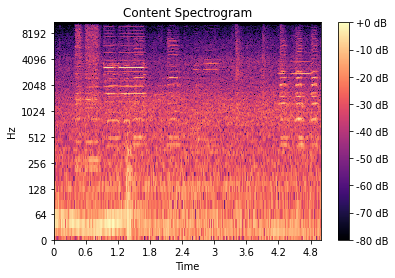

In [ ]:
R, fs = read_audio_spectrum(CONTENT_FILENAME)
print(R.shape)
print("range before scaling:",np.amin(R),np.amax(R))
a_cont = log_scale(R[:,:])
print("range after log scaling:",np.amin(a_cont),np.amax(a_cont))


#plot content spectrogram
plt.figure()
if INPUT_TYPE == 'stft':
    librosa.display.specshow(librosa.amplitude_to_db(R, ref=np.max), 
                                   hop_length=K_HOP, y_axis='log', 
                                   x_axis='time')
elif INPUT_TYPE == 'cqt':
    librosa.display.specshow(librosa.amplitude_to_db(R, ref=np.max), 
                             hop_length=K_HOP, bins_per_octave=BPO, 
                             x_axis='time', y_axis='cqt_hz')

plt.title('Content Spectrogram')
plt.colorbar(format="%+2.0f dB")


N_SAMPLES = a_cont.shape[1] #time bins
N_FREQ = a_cont.shape[0] #freq bins

a_cont = np.ascontiguousarray(a_cont[None,None,:,:]) #[batch,channels,freq,samples]

a_cont = torch.from_numpy(a_cont).permute(0,2,1,3) #pytorch:[batch,channels(freq),height(1),width(samples)]


cont_img = Variable(a_cont).type(dtype) #convert to pytorch variable
print("Input shape:", cont_img.data.shape) #check shape is correct


(513, 862)
Output range: 4.394256e-08 4.600955


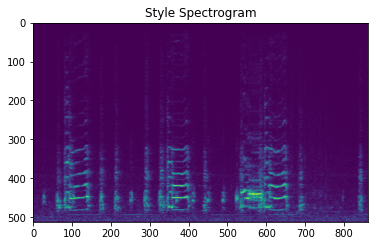

array([[0.36820135, 0.32223964, 0.22849391, ..., 0.24633144, 0.3221991 ,
        0.36233845],
       [0.36257634, 0.31768113, 0.16824912, ..., 0.08882778, 0.22820497,
        0.30735856],
       [0.29160258, 0.26821774, 0.24645084, ..., 0.52998245, 0.4509483 ,
        0.29977608],
       ...,
       [0.00260552, 0.00222558, 0.00131075, ..., 0.00067036, 0.00136126,
        0.00178157],
       [0.00262146, 0.00223808, 0.00130967, ..., 0.00068513, 0.00136587,
        0.0017785 ],
       [0.00262492, 0.00224139, 0.00131712, ..., 0.0006747 , 0.00136428,
        0.00178171]], dtype=float32)

In [ ]:
def imshow(tensor, channels=1, title=None):
    """ transforms pytorch tensor to numpy array and plots it out """
    
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.permute(0,2,1,3).contiguous() # get the dimensions in proper order
    image = image.view(N_FREQ,-1) # remove the fake batch dimension
    
    image = image.numpy() #convert pytorch tensor to numpy array
    print(image.shape) #check shape
    print("Output range:", np.amin(image),np.amax(image))
    
    plt.imshow(np.flipud(image))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    return image #return numpy array

"Just to check we can get back the numpy array with the correct shape"
plt.figure()
imshow(style_img.data, title='Style Spectrogram')

#plt.figure()
#imshow(content_img.data, title='Content Image')

In [ ]:
"Here we create the custom network"

N_FILTERS = 4096 # no. of filters in conv layers (same in each layer, modify CNN class to change this)
hor_filter = 11 # width of conv filter

IN_CHANNELS = N_FREQ


def weights_init(m):    
# custom weights initialization
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.001)


cnn = CNN(N_FILTERS, IN_CHANNELS, hor_filter)


print(cnn)
if use_cuda:
    cnn.cuda()
cnn.apply(weights_init) 
cnn.eval()
for param in cnn.parameters():
    param.requires_grad = False # layers are static, weights are not trained


# Add the style/content loss 'layer' after the specified layer:
content_layers_default = ['relu_3'] 
style_layers_default = ['relu_1', 'relu_2'] 

CNN(
  (layer1): Sequential(
    (0): Conv2d(513, 4096, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
    (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(4096, 4096, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
    (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(4096, 4096, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
    (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
)


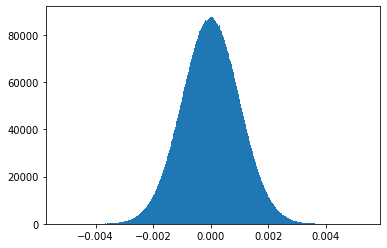

Max bin: 2.7856495e-05


In [ ]:
layer1w = cnn.layer1[0].weight.data.cpu()
layer1w = layer1w.numpy()
fig = plt.figure()
#plt.title('Style histogram')
ax = fig.add_subplot(111)
n,b,_ = ax.hist(layer1w.flatten(),bins='auto')
maxbin = np.argmax(n)
plt.show()
#fig.savefig('experiments/layer1weights.png',bbox_inches='tight')
print("Max bin:",b[maxbin])

Content loss
~~~~~~~~~~~~

The content loss is a function that takes as input the feature maps
$F_{XL}$ at a layer $L$ in a network fed by $X$ and
return the weigthed content distance $w_{CL}.D_C^L(X,C)$ between
this image and the content image. Hence, the weight $w_{CL}$ and
the target content $F_{CL}$ are parameters of the function. We
implement this function as a torch module with a constructor that takes
these parameters as input. The distance $\|F_{XL} - F_{YL}\|^2$ is
the Mean Square Error between the two sets of feature maps, that can be
computed using a criterion ``nn.MSELoss`` stated as a third parameter.

We will add our content losses at each desired layer as additive modules
of the neural network. That way, each time we will feed the network with
an input image $X$, all the content losses will be computed at the
desired layers and, thanks to autograd, all the gradients will be
computed. For that, we just need to make the ``forward`` method of our
module returning the input: the module becomes a ''transparent layer''
of the neural network. The computed loss is saved as a parameter of the
module.

Finally, we define a fake ``backward`` method, that just call the
backward method of ``nn.MSELoss`` in order to reconstruct the gradient.
This method returns the computed loss: this will be useful when running
the gradient descent in order to display the evolution of style and
content losses.




In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight): #weight here is the epsilon tuning (how much content vs style)
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() #* weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.weight * self.criterion(input, self.target) #input*self.weight
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

.. Note::
   **Important detail**: this module, although it is named ``ContentLoss``,
   is not a true PyTorch Loss function. If you want to define your content
   loss as a PyTorch Loss, you have to create a PyTorch autograd Function
   and to recompute/implement the gradient by the hand in the ``backward``
   method.

Style loss
~~~~~~~~~~

For the style loss, we need first to define a module that compute the
gram produce $G_{XL}$ given the feature maps $F_{XL}$ of the
neural network fed by $X$, at layer $L$. Let
$\hat{F}_{XL}$ be the re-shaped version of $F_{XL}$ into a
$K$\ x\ $N$ matrix, where $K$ is the number of feature
maps at layer $L$ and $N$ the lenght of any vectorized
feature map $F_{XL}^k$. The $k^{th}$ line of
$\hat{F}_{XL}$ is $F_{XL}^k$. We let you check that
$\hat{F}_{XL} \cdot \hat{F}_{XL}^T = G_{XL}$. Given that, it
becomes easy to implement our module:




In [ ]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() #a=batch size(=1)
                                  #b=number of feature maps
                                  #(c,d)=dimensions of a feat. map (N=c*d) -> for 1D conv c=1
        #features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
        features = input.view(b, a * c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * c * d)

The longer is the feature maps dimension $N$, the bigger are the
values of the gram matrix. Therefore, if we don't normalize by $N$,
the loss computed at the first layers (before pooling layers) will have
much more importance during the gradient descent. We dont want that,
since the most interesting style features are in the deepest layers!

Then, the style loss module is implemented exactly the same way than the
content loss module, but we have to add the ``gramMatrix`` as a
parameter:




In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight): #weight here is the alpha tuning (how much content vs style)
        super(StyleLoss, self).__init__()
        self.target = target.detach() #* weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss() #size_average=False

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        #self.G.mul_(self.weight)
        self.loss = self.weight * self.criterion(self.G, self.target) #target=gram mat for style img, G=gram mat for current input ie. noise
        return self.output

    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

In [ ]:
#rebuild network with the layers we want
def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight, content_weight,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []
    
    model = nn.Sequential()
    layer_list =  list(cnn.layer1) + list(cnn.layer2) + list(cnn.layer3)  #.layers
    
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    #here we rebuild the network adding the in content and style loss "layers"   
    i = 1  
    for layer in layer_list:
        
        if isinstance(layer, nn.Conv2d): #if layer in cnn belong to class nn.Conv2d
            name = "conv_" + str(i)
            model.add_module(name, layer) #add that layer to our sequential model
            
            if name in content_layers: #at the right depth add the content loss "layer"
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers: #at the right depth add the style loss "layer"
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU): #do the same for ReLUs
            name = "relu_" + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
            
        if isinstance(layer, nn.BatchNorm2d): #do the same for maxpool
            name = "batchnorm_" + str(i)
            model.add_module(name, layer)
            
            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                 
        if isinstance(layer, nn.MaxPool2d): #do the same for maxpool
            name = "pool_" + str(i)

            if POOL_TYPE == 'max':
                model.add_module(name, layer)
            elif POOL_TYPE == 'avg':
                avgpool = nn.AvgPool2d(kernel_size=layer.kernel_size, 
                                       stride=layer.stride, 
                                       padding=layer.padding)
                model.add_module(name, avgpool)
            
            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)
            
            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
            
            i += 1


    #for param in model.parameters():
    #    param.requires_grad = False
    return model, style_losses, content_losses

Input image
~~~~~~~~~~~

Again, in order to simplify the code, we take an image of the same
dimensions than content and style images. This image can be a white
noise, or it can also be a copy of the content-image.




In [ ]:
"""image to input in generative network"""

input_img = cont_img.clone()


Gradient descent
~~~~~~~~~~~~~~~~

As Leon Gatys, the author of the algorithm, suggested
`here <https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq>`__,
we will use L-BFGS algorithm to run our gradient descent. Unlike
training a network, we want to train the input image in order to
minimise the content/style losses. We would like to simply create a
PyTorch  L-BFGS optimizer, passing our image as the variable to optimize.
But ``optim.LBFGS`` takes as first argument a list of PyTorch
``Variable`` that require gradient. Our input image is a ``Variable``
but is not a leaf of the tree that requires computation of gradients. In
order to show that this variable requires a gradient, a possibility is
to construct a ``Parameter`` object from the input image. Then, we just
give a list containing this ``Parameter`` to the optimizer's
constructor:




In [ ]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

**Last step**: the loop of gradient descent. At each step, we must feed
the network with the updated input in order to compute the new losses,
we must run the ``backward`` methods of each loss to dynamically compute
their gradients and perform the step of gradient descent. The optimizer
requires as argument a "closure": a function that reevaluates the model
and returns the loss.

In [ ]:
def run_style_transfer(cnn, style_img, input_img, content_img, num_steps=500,
                       style_weight=1e8, content_weight=1):
    """Run the style transfer"""
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)
    
    print("Input range:", torch.max(input_param.data),torch.min(input_param.data))   
    print(model)
    print('Optimizing..')
    run = [0]

    while run[0] <= num_steps:

        def closure():

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward() #call backward method to grab the loss
            
            for cl in content_losses:
                content_score += cl.backward()
            
            total_loss = style_score + content_score
            
            if run[0] % 50 == 0:
                #print("reg", reg)
                #print(torch.max(input_param.data),torch.min(input_param.data))
                
                print("run {}:".format(run))
                print('Style Loss : {:4f}'.format(
                    style_score.item()))
                print('Content Loss : {:4f}'.format(
                       content_score.item()))
                print(torch.max(input_param.data),torch.min(input_param.data))
                print('Total Loss : {:4f}'.format(
                    total_loss.item()))
            
            run[0] += 1             
            return total_loss   
        
        optimizer.step(closure)

    return input_param.data

Finally, run the algorithm



Building the style transfer model..
Input range: tensor(4.7213, device='cuda:0') tensor(3.4601e-07, device='cuda:0')
Sequential(
  (conv_1): Conv2d(513, 4096, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
  (batchnorm_1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (pool_1): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (conv_2): Conv2d(4096, 4096, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
  (batchnorm_2): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_2): ReLU()
  (style_loss_2): StyleLoss(
    (gram): GramMatrix()
    (criterion): MSELoss()
  )
  (pool_2): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (conv_3): Conv2d(4096, 4096, kernel_size=(1, 11), stride=(1, 1), padding=(0, 5))
  (batchnorm_3): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_ru

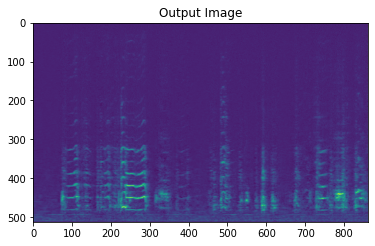

In [ ]:
outputs = []
i = 0
#print(cont_img.data.shape)
while i < runs:
    
    output = run_style_transfer(cnn, style_img, input_img, cont_img)

    fig3 = plt.figure()
    out = imshow(output, title='Output Image')
 #   fig3.savefig('experiments/'+outname+'/'+savename_style+'_output'+'.png',bbox_inches='tight')
    outputs.append(out)
    i += 1

# sphinx_gallery_thumbnail_number = 4
plt.show()

Range from opt: -0.5711454 5.506609


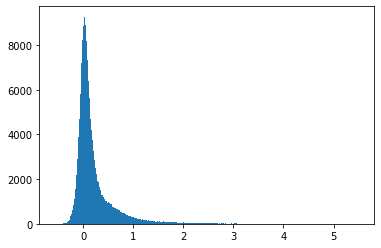

Range after undoing all scaling: -0.43512195 245.31445


In [ ]:
#out_spec = inv_scale(out,shf)
for j in range(len(outputs)):
    print("Range from opt:",np.amin(outputs[j]),np.amax(outputs[j])) # check values make sense
    fig4 = plt.figure()
    #plt.title('Style histogram')
    ax = fig4.add_subplot(111)
    n,b,_ = ax.hist(outputs[j].flatten(),bins='auto')
    plt.show()
#    fig4.savefig('experiments/'+outname+'/'+savename_style+'_output'+'_hist.png',bbox_inches='tight')
    
out_spec = [inv_log(x) for x in outputs]

for j in range(len(out_spec)):
    print("Range after undoing all scaling:",np.amin(out_spec[j]),np.amax(out_spec[j])) # check values make sense

Convert the output spectrogram back to a time-domain audio signal.

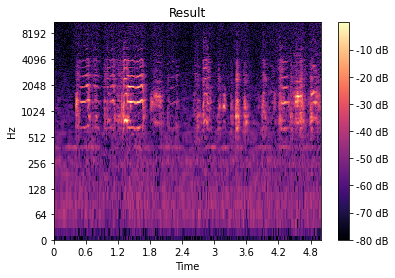

In [ ]:
for index, value in enumerate(out_spec):
    if INPUT_TYPE == 'stft':
        x = librosa.griffinlim(value, hop_length=K_HOP, win_length=N_FFT)
    elif INPUT_TYPE == 'cqt':
        x = librosa.griffinlim_cqt(value, hop_length=K_HOP, bins_per_octave=BPO)

    librosa.output.write_wav(savename_style + '_' + str(index) + '.wav', x, fs)
    plt.figure()
    if INPUT_TYPE == 'stft':
        librosa.display.specshow(librosa.amplitude_to_db(value, ref=np.max), 
                                   hop_length=K_HOP, y_axis='log', 
                                   x_axis='time')
    elif INPUT_TYPE == 'cqt':
        librosa.display.specshow(librosa.amplitude_to_db(value, ref=np.max), 
                             hop_length=K_HOP, bins_per_octave=BPO, 
                             x_axis='time', y_axis='cqt_hz')

    plt.title('Result')
    plt.colorbar(format="%+2.0f dB")

plt.ioff()